In [1]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split
from keras.utils.vis_utils import plot_model
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('omw-1.4')

In [4]:
%run SharedFunctions.ipynb

Učitavamo podatke, i izdvajamo samo toksične

In [5]:
data = pd.read_csv('data/data_longer.csv')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [6]:
get_label_counts(data, labels)

{'toxic': 21384,
 'severe_toxic': 1962,
 'obscene': 12140,
 'threat': 689,
 'insult': 11304,
 'identity_hate': 2117}

## DataAugmentation

U ovoj svesci, pokušaćemo da uvećamo broj instanci manjinskih klasa pomoću biblioteke nlpaug: https://github.com/makcedward/nlpaug/tree/40794970124c26ce2e587e567738247bf20ebcad#nlpaug

Ova biblioteka omogućava uvećavanje tekstualnih podataka kreiranjem veštačkih. Postoje veliki broj različitih metoda augmentacije, od kojih su ovde iskorišćena 4. Korišćeni su:
- RandomWordAug koji na osnovu datog teksta kreira sličan tako što nasumično izbaci nekoliko reči iz teksta.
- SynonymAug koji na osnovu datog teksta kreira sličan tako što zameni reči njihovim sinonimima
- KeyboardAug koji na osnovu datog teksta kreira sličan tako što menja neke karaktere njima bliskim na tastaturi, i tako simulira greške u kucanju
- OcrAug koji na osnovu datog teksta kreira sličan tako što menja slova ciframa ili drugim karakterima koji se često koriste u pisanju (npr. o i 0, ili b i 6)

In [7]:
aug1 = naw.RandomWordAug()
aug2 = naw.SynonymAug(aug_src='wordnet')
aug3 = nac.KeyboardAug()
aug4 = nac.OcrAug()

In [8]:
train_data, test_data = model_selection.train_test_split(data, test_size=0.4)

Uvećavamo broj instanci klase threat, identity_hate i severe_toxic, pošto se na njima prethodni model slabo pokazao

In [9]:
train_threat = train_data[train_data['threat']==1]
train_identity_hate = train_data[train_data['identity_hate']==1]
train_severe = train_data[train_data['severe_toxic']==1]

Klasu threat ćemo uvećati 4 puta, a druge dve 2 puta

In [10]:
augmented_text_threat1 = aug1.augment(list(train_threat['comment_text']))
augmented_text_threat2 = aug2.augment(list(train_threat['comment_text']))
augmented_text_threat3 = aug3.augment(list(train_threat['comment_text']))
augmented_text_threat4 = aug4.augment(list(train_threat['comment_text']))

augmented_text_identity = aug1.augment(list(train_identity_hate['comment_text']))
augmented_text_severe = aug1.augment(list(train_severe['comment_text']))

In [11]:
text = list(train_data['comment_text'])
len(text)

13480

In [12]:
text.extend(augmented_text_threat1)
text.extend(augmented_text_threat2)
text.extend(augmented_text_threat3)
text.extend(augmented_text_threat4)

text.extend(augmented_text_identity)
text.extend(augmented_text_severe)

In [13]:
label_threat1 = train_threat[labels]
label_threat2 = train_threat[labels]
label_threat3 = train_threat[labels]
label_threat4 = train_threat[labels]

label_identity = train_identity_hate[labels]
label_severe = train_severe[labels]

In [14]:
X_train = pd.DataFrame(text)

In [15]:
y_train = pd.DataFrame(pd.concat([train_data[labels], label_threat1, label_threat2, label_threat3, label_threat4, label_identity, label_severe]))

In [16]:
X_train.shape, y_train.shape

((17618, 1), (17618, 6))

In [17]:
get_label_counts(y_train, labels)

{'toxic': 16805,
 'severe_toxic': 3010,
 'obscene': 10407,
 'threat': 2252,
 'insult': 9995,
 'identity_hate': 3226}

In [18]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [19]:
word_index, tokenizer = get_vocabulary(max_features, X_train[0], 'tokenizer_multi2.pickle')

In [20]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 36959


In [21]:
X_train_transformed = to_sequence(X_train[0], max_len, tokenizer)
X_test_transformed = to_sequence(test_data['comment_text'], max_len, tokenizer)

In [22]:
X_train_transformed.shape, X_test_transformed.shape

((17618, 100), (8988, 100))

In [23]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)

In [24]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.2
embedding_dim = 100
lr = 0.01
layers = 0

In [25]:
multi_model = create_model(num_of_classes = 6, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

In [26]:
weights = get_weights(y_train[labels].to_numpy(), 6)
weights

{0: 0.17472974313200437,
 1: 0.9755260243632337,
 2: 0.28214983504692354,
 3: 1.3038780343398462,
 4: 0.2937802234450559,
 5: 0.9102087208100847}

In [27]:
epochs = 20
batch_size = 64

In [28]:
start = time.time()    

multi_history = multi_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                validation_split=0.2,
                                class_weight=weights, verbose=False, shuffle=True)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Trajanje obucavanja modela multilabel klasifikacije:  77.5646448135376


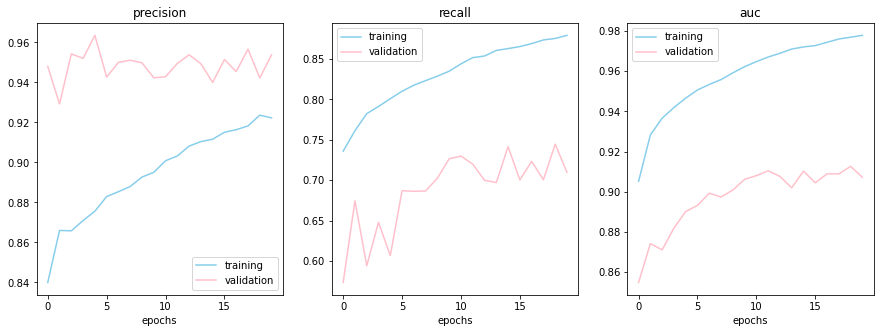

In [29]:
plot_graphs(multi_history, ['precision', 'recall', 'auc'])

Sa grafika može da se zaključi da je augmentacija dovela do preprilagođavanja

In [30]:
scores = multi_model.evaluate(X_train_transformed, y_train)
print('Train Loss: ', scores[0])
print('Train Precision: ', scores[1])
print('Train Recall: ', scores[2])
print('Train AUC:', scores[3])
print('Train F1: ', scores[4])

551/551 [==============================] - 2s 4ms/step - loss: 0.2352 - precision: 0.9521 - recall: 0.8412 - auc: 0.9674 - f1_m: 0.9005
Train Loss:  0.23515263199806213
Train Precision:  0.9521191120147705
Train Recall:  0.8411861062049866
Train AUC: 0.9674386978149414
Train F1:  0.9004679918289185


In [31]:
scores = multi_model.evaluate(X_test_transformed, test_data[labels])
print('Test Loss: ', scores[0])
print('Test Precision: ', scores[1])
print('Test Recall: ', scores[2])
print('Test AUC:', scores[3])
print('Test F1: ', scores[4])

281/281 [==============================] - 1s 5ms/step - loss: 0.4065 - precision: 0.8412 - recall: 0.7909 - auc: 0.9287 - f1_m: 0.8145
Test Loss:  0.4064769148826599
Test Precision:  0.8411922454833984
Test Recall:  0.7909407615661621
Test AUC: 0.9287353754043579
Test F1:  0.814470112323761


In [32]:
y_predicted = multi_model.predict(X_test_transformed)

In [33]:
# Bolje da imamo vise lazno pozitivnih nego lazno negativnih

def translate(array):
    
    res1 = [1 if x>0.4 else 0 for x in array[::2]]
    res2 = [1 if x>0.2 else 0 for x in array[1::2]]

    res = []
    for r1, r2 in zip(res1, res2):
        res.append(r1)
        res.append(r2)

    return res

result = map(translate, y_predicted)

y_labels = list(result)
cf = multilabel_confusion_matrix(test_data[labels], y_labels)

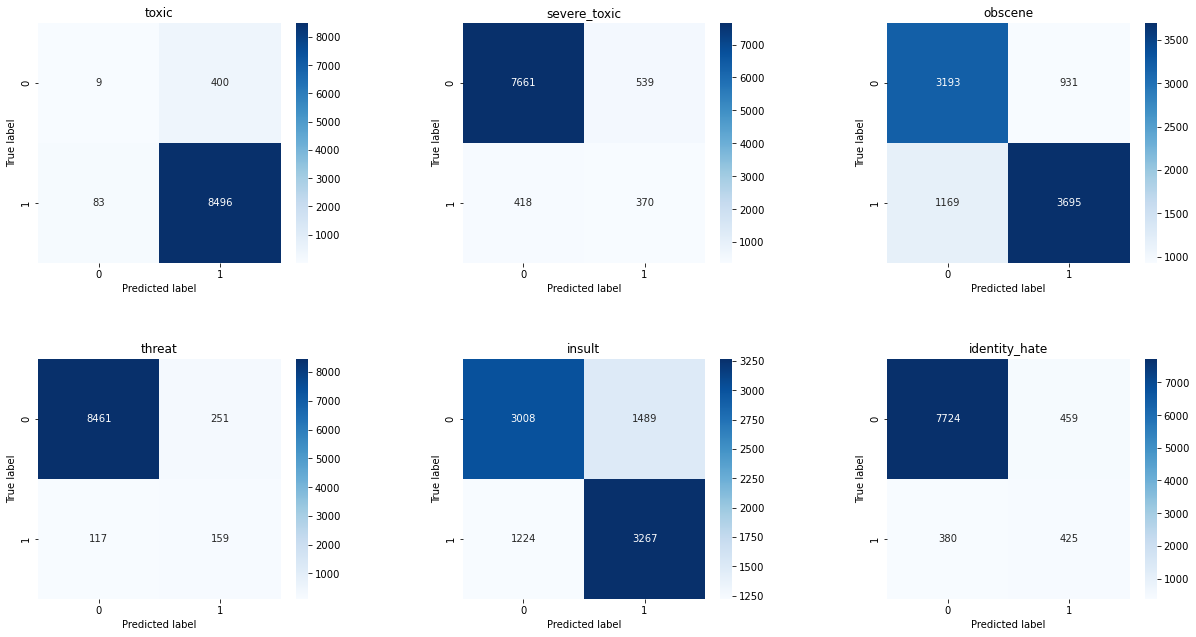

In [34]:
plot_cf(cf, 'multi_aug', labels)

In [35]:
print('Brojnost po klasama na test skupu:')
print(get_label_counts(test_data[labels], labels))

Brojnost po klasama na test skupu:
{'toxic': 8579, 'severe_toxic': 788, 'obscene': 4864, 'threat': 276, 'insult': 4491, 'identity_hate': 805}


In [36]:
print(metrics.classification_report(test_data[labels], y_labels,target_names=labels))

               precision    recall  f1-score   support

        toxic       0.96      0.99      0.97      8579
 severe_toxic       0.41      0.47      0.44       788
      obscene       0.80      0.76      0.78      4864
       threat       0.39      0.58      0.46       276
       insult       0.69      0.73      0.71      4491
identity_hate       0.48      0.53      0.50       805

    micro avg       0.80      0.83      0.81     19803
    macro avg       0.62      0.68      0.64     19803
 weighted avg       0.81      0.83      0.82     19803
  samples avg       0.82      0.85      0.80     19803



C:\Users\panap\anaconda3\envs\envi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
precisions, recalls, f1_scores = get_prec_rec_f1(cf, labels)

In [38]:
precisions

{'toxic': 0.96,
 'severe_toxic': 0.41,
 'obscene': 0.8,
 'threat': 0.39,
 'insult': 0.69,
 'identity_hate': 0.48}

In [39]:
recalls

{'toxic': 0.99,
 'severe_toxic': 0.47,
 'obscene': 0.76,
 'threat': 0.58,
 'insult': 0.73,
 'identity_hate': 0.53}

In [40]:
f1_scores

{'toxic': 0.97,
 'severe_toxic': 0.44,
 'obscene': 0.78,
 'threat': 0.47,
 'insult': 0.71,
 'identity_hate': 0.5}

In [44]:
# izracunate metrike se cuvaju u csv datoteku: 

report1 = pd.DataFrame(precisions, index=['precision'])
report2 = pd.DataFrame(recalls, index=['recall'])
report3 = pd.DataFrame(f1_scores, index=['f1'])

report = pd.concat([report1, report2, report3])

report.to_csv('data/report2.csv')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
precision,0.96,0.41,0.80,0.39,0.69,0.48
recall,0.99,0.47,0.76,0.58,0.73,0.53
f1,0.97,0.44,0.78,0.47,0.71,0.50


U odnosu na model iz prethodne sveske, jedino se povećao odziv za klasu threat, ostalo je sve prilično slično.

In [41]:
multi_model.save_weights('models/multi_model_aug_weights.hdf5')
multi_model.save('models/multi_model_aug.hdf5')